# NB-HI8: Plot of PET and dryness over three 30yr period for each GCM

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)

mpl.rcParams['xtick.labelsize']='small'


The Python version: 3.7.0
xarray 0.16.2
pandas 1.2.1


In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_monthly_historical_hydro_datasets, resample_data
from cmip5_oconus.data_catalog import load_monthly_cmip5_hydro_datasets
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize

Last executed: 2021-08-05 13:40:39.950859 by mizukami on crhtc46


In [3]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=9, threads=4, memory="108GB",
#                  walltime='00:40:00')
#cluster.scale(jobs=3)


In [4]:
#from dask.distributed import Client
#client = Client(cluster)

In [5]:
#client

-------------------------
## Setup 

In [6]:
figSave = True

In [7]:
region           = 'HI'
gcms             = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
period_hist      = slice('1970-01-01', '1999-12-31')
period_10yr_hist = slice('1990-01-01', '1999-12-31')
pet_vars  = ['PRCP', 'OUT_PET_NATVEG']

## Load the data

In [8]:
xr.set_options(file_cache_maxsize=12000)
histo_data = load_monthly_historical_hydro_datasets(models=gcms, variables=pet_vars, region=region, parallel=False)

load_monthly_historical_hydro_datasets
load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [02:05<00:00, 12.58s/it]

load_obs_dataset


## 30 year (1970-1999) annual mean

In [10]:
%%time
histo_means = {}
for name in ['obs', 'gcm']:
    histo_means[name] = resample_data(histo_data[name].sel(time=period_hist), region=region, freq='AS').mean('time').compute()

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 9.65 s, sys: 8.99 s, total: 18.6 s
Wall time: 47.6 s


## 10 year (1990-1999) annual mean

In [11]:
histo_10yr_means = {}
for name in ['obs', 'gcm']:
    histo_10yr_means[name] = resample_data(histo_data[name].sel(time=period_10yr_hist), region=region, freq='AS').mean('time').compute()

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Additional process - compute dryness index, and cleanup

In [12]:
# compute dryness
for name in ['obs', 'gcm']:
    histo_means[name]['dryness'] = histo_means[name]['OUT_PET_NATVEG']/histo_means[name]['PRCP']
    histo_10yr_means[name]['dryness'] = histo_10yr_means[name]['OUT_PET_NATVEG']/histo_10yr_means[name]['PRCP']

### Plot

In [13]:
# create colormap
# ---------------

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.Spectral_r(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(0.9, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

## 30 year (1970-1999) annual mean plot

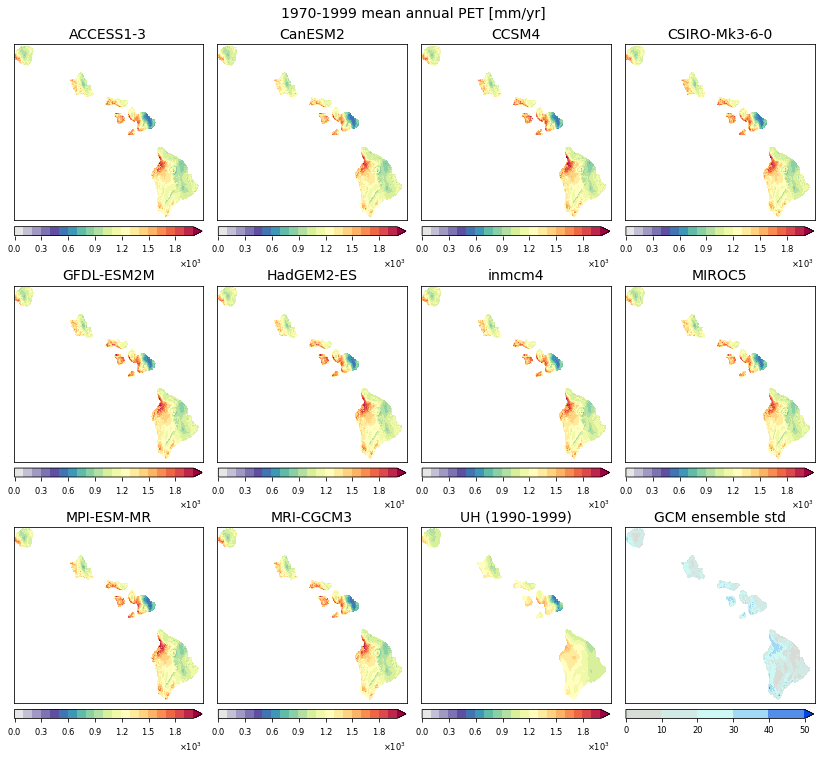

In [18]:
var="OUT_PET_NATVEG"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'levels': 21, 'vmin':0, 'vmax':2000, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'levels': 6, 'vmin':0, 'vmax':50,  'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['UH (1990-1999)','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_means['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        histo_means['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_means['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
#plt.tight_layout()
fig.suptitle('1970-1999 mean annual PET [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI8_Fig1_annual_mean_{var}_hist.png', dpi=300)

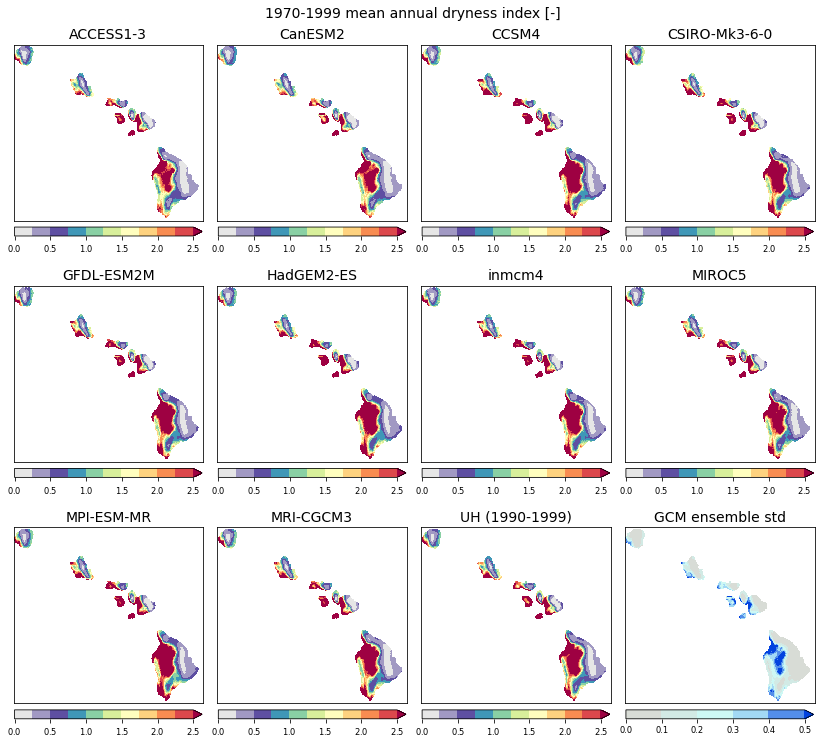

In [19]:
var="dryness"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'levels': 11, 'vmin':0, 'vmax':2.5, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'levels': 6, 'vmin':0, 'vmax':0.5, 'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['UH (1990-1999)','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_means['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        histo_means['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_means['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)

fig.suptitle('1970-1999 mean annual dryness index [-]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI8_Fig2_annual_mean_{var}_hist.png', dpi=300)

## 10 year (1990-1999) annual mean plot

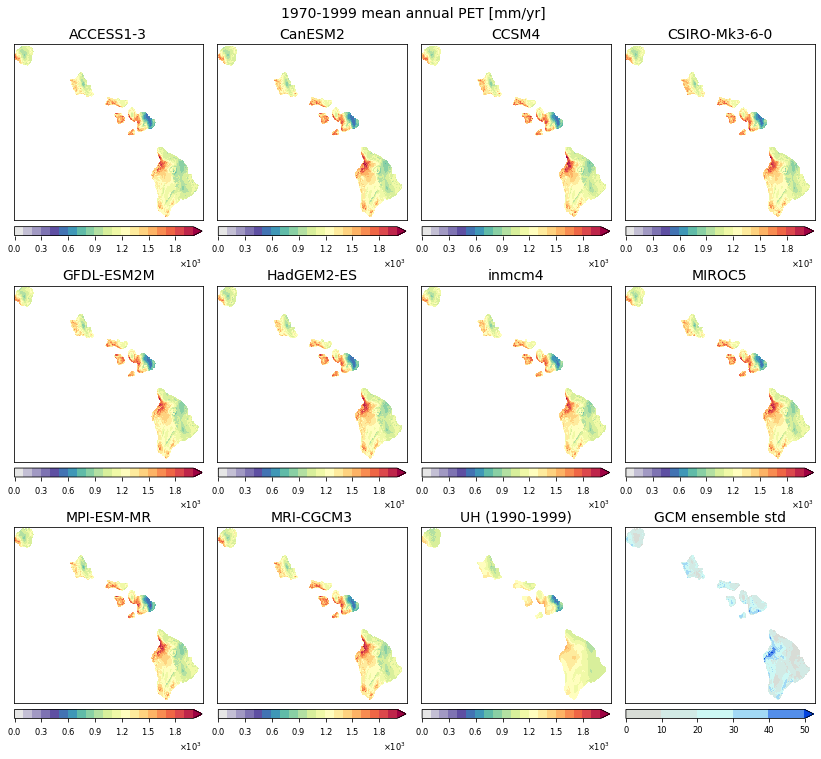

In [21]:
var="OUT_PET_NATVEG"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'levels': 21, 'vmin':0, 'vmax':2000, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'levels': 6, 'vmin':0, 'vmax':50,  'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['UH (1990-1999)','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_10yr_means['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        histo_10yr_means['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_10yr_means['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
#plt.tight_layout()
fig.suptitle('1970-1999 mean annual PET [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI8_Fig3_annual_mean_{var}_10yr_hist.png', dpi=300)

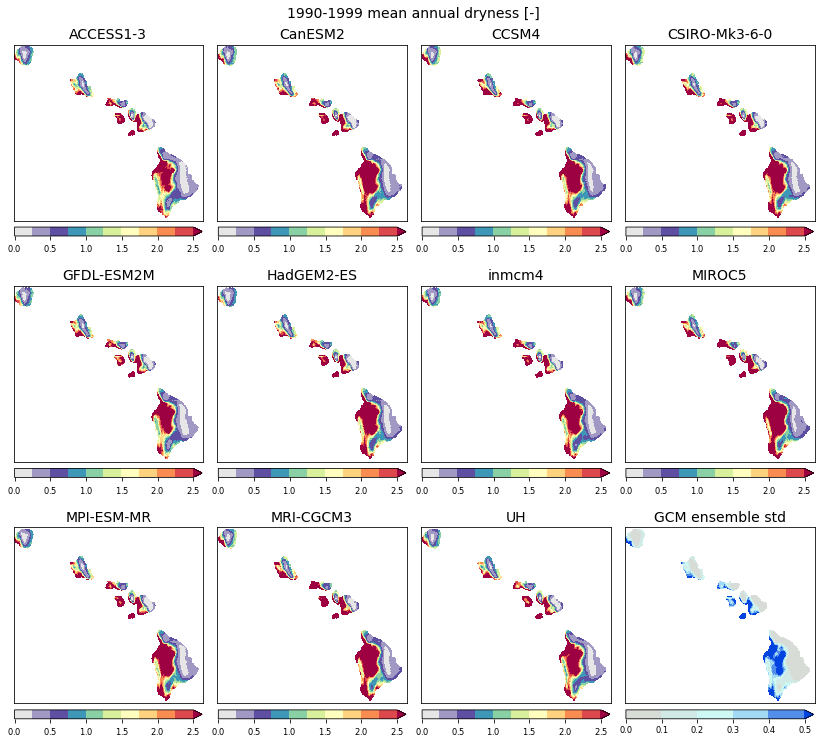

In [22]:
var="dryness"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'levels': 11, 'vmin':0, 'vmax':2.5, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'levels': 6, 'vmin':0, 'vmax':0.5, 'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['UH','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_10yr_means['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        histo_10yr_means['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_10yr_means['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
fig.suptitle('1990-1999 mean annual dryness [-]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI8_Fig4_annual_mean_{var}_10yr_hist.png', dpi=300)

### Below is for checking random things

In [ ]:
ds_rcp85_mon = ds_rcp85.groupby('time.month').mean(dim="time")

Long-term seasonal mean

In [ ]:
ds_rcp85_season = ds_rcp85.groupby('time.season').mean(dim="time")